# Analyze Wallscheid LPTN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy
import torch
import scipy.io as sio
from tqdm import tqdm
from joblib import Parallel, delayed
from mawkutils.data import KaggleDataSet, DBManager as DBM
from mawkutils.topology import WallscheidLPTN, DifferenceEqLayer, LPTNTorch
from mawkutils.render import prettify
#from hpo_lptn_4_diss import param_space as param_bounds


DATA_PATH = Path().cwd().parent / "data" / "input"
DATA_OUT_PATH = DATA_PATH.parent / 'output' / 'misc'
IMG_PATH = Path().cwd().parent / 'notebooks' / 'img'

In [2]:
ds = KaggleDataSet(with_extra_cols=True)
ds.featurize(scheme='basic')
# add interpolated ploss and schlepp

In [3]:
mdl = WallscheidLPTN(ds.target_cols)

In [4]:
# load up LUTs
ploss_tup = sio.loadmat(DATA_PATH / 'Losses_250V.mat')['Losses'][0][0]
ploss_lut = pd.DataFrame(ploss_tup[2], index=ploss_tup[0].ravel(),
                         columns=ploss_tup[1].ravel())
schlepp_tup = sio.loadmat(DATA_PATH / 'Schleppkennlinie.mat')['Schlepp'][0][0]
schlepp_arr = np.array([schlepp_tup[0], schlepp_tup[1]]).squeeze()
schlepp_lut = pd.Series(schlepp_arr[1], index=schlepp_arr[0])


In [5]:
# add LUT info to dataframe
codes, uniques = ploss_lut.index.factorize(sort=False)
idx_map = {k:v for k, v in zip(uniques, codes)}
codes, uniques = ploss_lut.columns.factorize(sort=False)
col_map = {k:v for k, v in zip(uniques, codes)}
ds.data.loc[:, 'iron_loss'] =\
     ploss_lut.to_numpy()[(np.sign(ds.data.torque.to_numpy()) * (np.round(ds.data.i_s / np.sqrt(2) / 2.5) * 2.5)).map(idx_map),
                    (np.round(ds.data.motor_speed.abs() / 100) * 100).map(col_map)]

ds.data['schlepp'] = schlepp_lut.loc[
    (np.round(ds.data.motor_speed.abs() / 100) * 100).tolist()].to_numpy()

In [6]:
ds.data.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,1330816.0,24.565256,1.929522,8.783478,23.184804,24.797327,26.217019,30.714205
coolant,1330816.0,36.229995,21.786149,10.623751,18.698135,26.900141,49.857487,101.598512
u_d,1330816.0,-25.133809,63.091972,-131.530411,-78.690904,-7.429755,1.470271,131.469788
u_q,1330816.0,54.279005,44.173234,-25.290930,12.069925,48.938181,90.034393,133.036994
motor_speed,1330816.0,2202.080728,1859.663350,-275.549144,317.110665,1999.976685,3760.639058,6000.015137
i_d,1330816.0,-68.716810,64.933233,-278.003632,-115.406060,-51.093763,-2.979688,0.051897
i_q,1330816.0,37.412782,92.181880,-293.426793,1.095863,15.774007,100.612150,301.707855
torque,1330816.0,31.106032,77.135755,-246.466663,-0.137427,10.860354,91.597176,261.005707
i_s,1330816.0,107.544575,85.262537,0.000039,11.828189,110.620016,172.141884,361.515337
u_s,1330816.0,81.640420,53.335070,0.000002,18.900277,107.709120,130.782849,134.264098


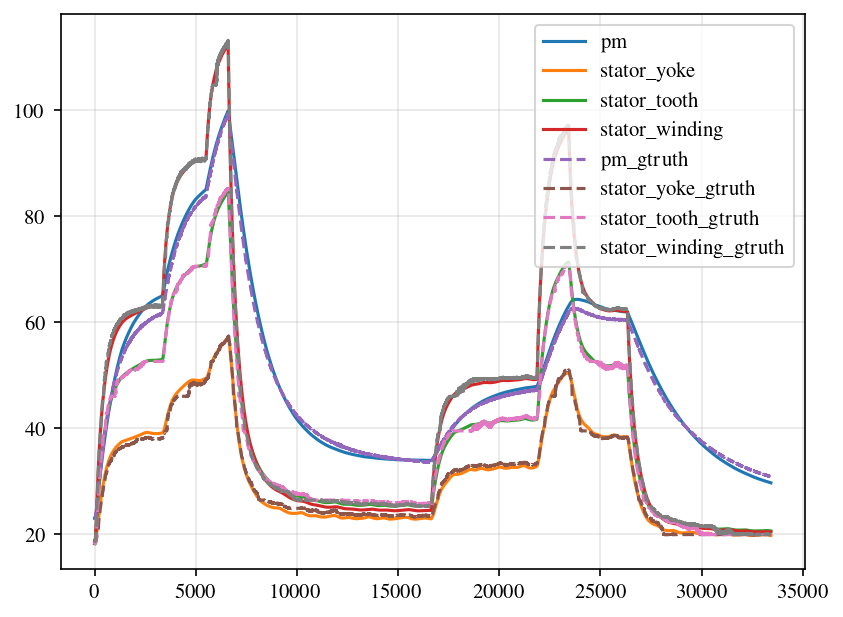

In [7]:
# initial test
p1 = ds.data.groupby(ds.pid).get_group(4).reset_index(drop=True)
excit_vals = p1.loc[:, ['motor_speed', 'iron_loss', 'schlepp', 'i_s', 'ambient', 'coolant']].to_numpy()
x_traj = mdl.solve_ivp(inp_df=p1)
plt.figure(dpi=150)
plt.plot(x_traj, label=mdl.target_cols)
plt.plot(p1.loc[:, ds.target_cols].to_numpy(), label=[f"{c}_gtruth" for c in mdl.target_cols], ls='--')
#plt.plot((excit_vals / np.abs(excit_vals).max() * 100)[:, :-2], label=['motor_speed', 'iron_loss', 'schlepp', 'i_s'])
#plt.plot(excit_vals[:, -2:], label=['ambient', 'coolant'])
plt.legend(loc='upper right')
#plt.xlim(15000, 20000)
#plt.ylim(0, 50)


In [8]:
#%%timeit
#mdl.solve_ivp(inp_df=p1)

In [11]:
# solve all profiles
def evaluate_all_profiles():
    mse_l = []
    for pid, df in ds.data.groupby(ds.pid, sort=False):
        y_hat = np.clip(mdl.solve_ivp(df.reset_index(drop=True)), -100, 300)  # arbitrary
        gtruth = df.loc[:, mdl.target_cols].to_numpy()
        mse_l.append(np.mean((y_hat-gtruth)**2))
    return np.mean(mse_l)

In [12]:
#%%timeit
evaluate_all_profiles()

2.9651712310300242

# Visualization of Trainings

## Visualize random search

In [13]:
randsearch_stats = pd.read_csv(DATA_OUT_PATH / "random_search.csv")


Text(0.5, 0, 'Random search iteration')

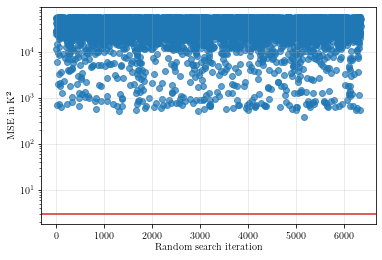

In [14]:
randsearch_stats = randsearch_stats.dropna(axis=0)#.query("values < 20")
plt.scatter(np.arange(len(randsearch_stats)), randsearch_stats.loc[:, 'MSE'], alpha=0.7)
plt.axhline(3.0, color='tab:red')
#plt.ylim(0, 10)
plt.yscale("log")
plt.ylabel("MSE in K²")
plt.xlabel('Random search iteration')

## Visualize HPO

In [13]:
hpo_stats = pd.read_pickle(DATA_OUT_PATH / 'custom_hpo_lptn.pkl.zip')
hpo_stats

,caps0,caps1,caps2,caps3,const_Rs_sy_sw,const_Rs_sy_st,const_Rs_sw_st,lin_Rs_slope,lin_Rs_bias,exp_Rs_magn0,...,ploss_alpha_ac_2,ploss_beta_cu,ploss_k_1_0,ploss_k_1_1,ploss_k_1_2,ploss_k_1_3,ploss_k_2,ploss_alpha_fe,schlepp_factor,values
0,750.277291,1461.663688,980.544142,758.456852,0.045818,0.060614,0.105844,-0.006266,0.009730,1.678983,...,0.248529,3.785571,0.531215,0.219875,0.445462,-0.294769,0.786651,-0.008139,2.549667,NaN
1,7624.813168,17802.395705,1503.310735,8916.813391,0.060448,0.045830,0.086460,-0.004463,0.011907,0.649019,...,0.223604,3.163407,0.202149,0.397967,0.342344,-0.678480,0.692048,-0.003869,0.422541,525.135157
2,8678.079530,2901.766056,100.000000,2482.316651,0.080083,0.034104,0.054592,-0.005220,0.011622,0.802157,...,0.274636,2.838430,0.327072,0.000000,0.443277,-0.239034,0.405933,-0.002545,2.424731,NaN
3,4244.836710,2125.244892,4629.721827,1583.934782,0.048857,0.023246,0.046023,-0.003931,0.000875,1.684561,...,0.611877,2.434050,0.719426,0.121947,0.689110,-0.618355,0.469824,-0.003581,1.556070,NaN
4,9798.583143,2566.898829,141.359209,2300.898331,0.050429,0.048130,0.104850,-0.005674,0.007751,0.486154,...,0.436315,3.374732,0.406018,0.097544,0.181470,-0.636228,0.830023,-0.002555,2.764425,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,7675.607812,594.173996,1612.197187,9438.885810,0.103696,0.060063,0.048465,-0.004333,0.005492,1.330861,...,0.173422,2.289033,0.808207,0.460304,0.157859,-0.098821,0.738989,-0.007376,1.264665,NaN
1199996,20868.458486,128.680438,2335.605222,4967.194218,0.030238,0.299865,0.109598,-0.005238,0.016954,3.042541,...,0.482986,2.797148,0.393097,0.308241,0.343405,-0.791406,0.660483,-0.007398,4.393216,NaN
1199997,7286.614564,13535.704031,465.460425,3738.910545,0.214926,0.016685,0.069737,-0.005170,0.001678,1.611144,...,0.214491,2.019373,0.500653,0.250018,0.334970,-0.642581,0.443302,-0.002036,0.609037,324.327230
1199998,27849.365529,9922.065738,1583.080541,5471.586389,0.108904,0.095826,0.288423,-0.005169,0.030188,0.865078,...,0.302019,2.440284,0.451277,0.330703,0.026525,-0.487150,0.577411,-0.005587,1.710970,NaN


In [14]:
hpo_coeffs = hpo_stats.dropna(axis=0).query("values < 20").iloc[:, :-1].to_numpy()  # evaluate only good ones

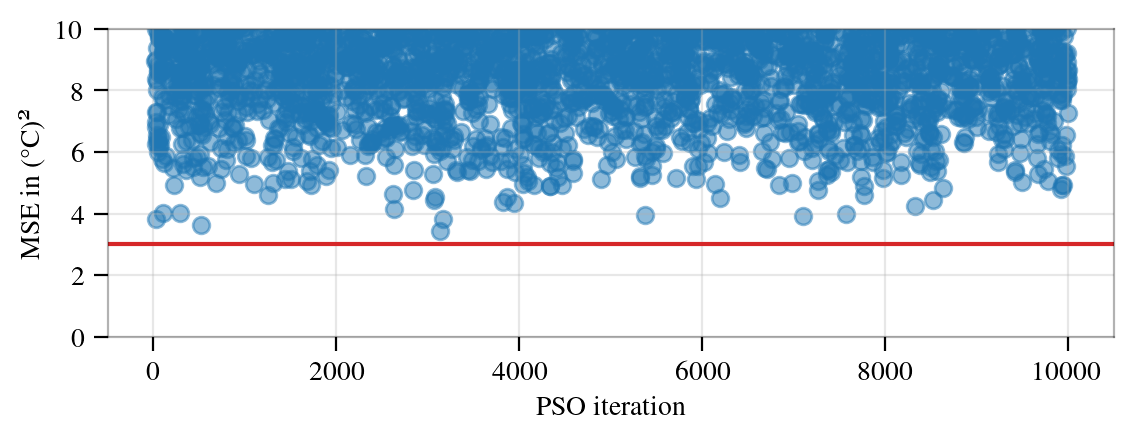

In [15]:
# hpo trend
fig = plt.figure(figsize=(6.49, 2), dpi=200)
hpo_trend_mse = hpo_stats.assign(iter=np.repeat(np.arange(10_000), 120)).dropna(axis=0).query("values < 20")
plt.scatter(hpo_trend_mse.loc[:, 'iter'], hpo_trend_mse.loc[:, 'values'], alpha=0.5)
plt.axhline(3.0, color='tab:red')
plt.ylim(0, 10)
plt.ylabel("MSE in (°C)²")
plt.xlabel('PSO iteration')
prettify(fig.gca())
plt.savefig(IMG_PATH / "diss_lptn_pso_trend.pdf", dpi = 300, bbox_inches = "tight")


In [16]:
genset = [16, 20, 48, 53, 60]
def evaluate_coeffs_on_certain_profiles(coeffs_arr, p_set):
    mse_l = []
    l_infty_l = []
    mdl = WallscheidLPTN(ds.target_cols, coeffs_list=coeffs_arr)
    for pid, df in ds.data.query(f"{ds.pid} in @p_set").groupby(ds.pid):
        y_hat = np.clip(mdl.solve_ivp(df.reset_index(drop=True)), -100, 300)  # arbitrary
        gtruth = df.loc[:, mdl.target_cols].to_numpy()
        mse = np.mean((y_hat-gtruth)**2)
        l_infty = np.max(np.abs(y_hat - gtruth))
        mse_l.append(mse)
        l_infty_l.append(l_infty)
    return np.mean(mse_l), np.max(np.array(l_infty_l))


In [13]:
mses, linftys = [], []
pbar = tqdm(range(hpo_coeffs.shape[0]))
with Parallel(n_jobs=-1) as prll:
    ret = prll(delayed(evaluate_coeffs_on_certain_profiles)(tuple(hpo_coeffs[r]), genset) 
               for r in pbar)
    mses, linftys = list(zip(*ret))


100%|██████████| 15215/15215 [08:27<00:00, 29.96it/s]


In [17]:
# sanity check
evaluate_coeffs_on_certain_profiles(WallscheidLPTN(ds.target_cols).coeffs_list, genset)

(1.9644631629919496, 7.3148254235166945)

In [24]:
pd.DataFrame({'MSE': mses, 'l_infty': linftys}).describe()

,MSE,l_infty
count,14003.000000,14003.000000
mean,77.771851,41.790137
std,124.466773,49.419576
min,5.978944,13.854283
25%,9.162656,18.834909
50%,38.747209,27.420843
75%,64.050104,34.759374
max,460.145942,195.235878


(0.0, 75.0)

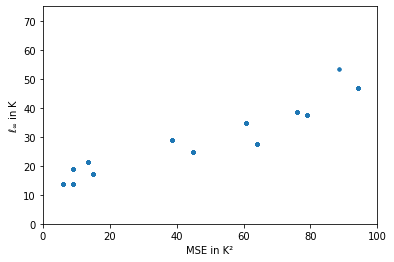

In [46]:
# genset performance of HP-optimal models (from PSO)
plt.scatter(mses, linftys, s=10)
#plt.xlim(0, 10)
plt.xlabel("MSE in K²")
plt.ylabel("$\\ell_\\infty$ in K")
plt.xlim(0, 100)
plt.ylim(0, 75)

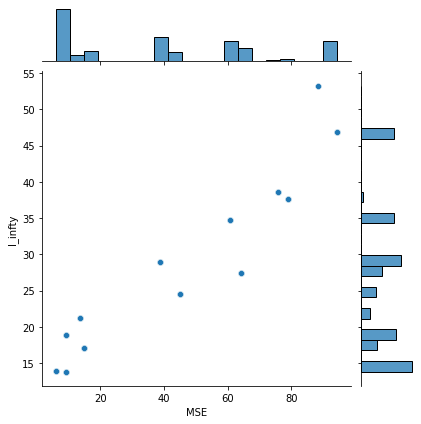

In [29]:
sns.jointplot(data=pd.DataFrame({'MSE': mses, 'l_infty': linftys}).query("MSE < 100 and l_infty < 75"), x='MSE', y='l_infty')

# 2nd Order Optimization

## Scipy Solvers

In [17]:
# visualize something
# for optimization, see script "run_scipy_opt_lptn_4_diss.py"
top5_TNC_optimized_coeffs = \
    [np.array([ 1.05875053e+04,  4.62654811e+03,  2.80319911e+02,  4.49772510e+03,
            3.53816979e-02,  7.70033450e-02,  9.03271676e-02, -5.26810231e-03,
            1.76251392e-02,  1.14711319e+00,  7.90711571e-01,  6.17758272e-01,
            1.91840884e-01,  1.43245865e-01,  1.39961253e-01,  2.65259313e-01,
            1.90462988e-01,  1.09335237e-01,  4.62492426e-01, -3.56177865e-01,
            1.31087232e-05,  3.33844366e-01,  1.53146997e-02,  2.56795103e-03,
            6.07103820e-01,  2.31395131e-01,  2.60692681e+00,  5.48781526e-01,
            2.81711318e-02,  6.84080333e-02, -8.79389511e-01,  9.33183092e-01,
        -9.78983405e-04,  1.73167514e+00]),
    np.array([ 9.98405921e+03,  6.79728046e+03,  1.96260158e+02,  3.76618633e+03,
            3.71921883e-02,  6.75609680e-02,  9.32230335e-02, -5.07517922e-03,
            1.81130812e-02,  1.86883087e+00,  6.16223220e-01,  6.62690857e-01,
            1.47964966e-01,  1.23303715e-01,  1.25246201e-01,  2.42993320e-01,
            2.47743624e-01,  1.09759402e-01,  3.97655583e-01, -2.78869256e-01,
            8.98252973e-02,  3.40403889e-01,  1.52308311e-02,  1.73895398e-03,
            4.91793230e-01,  2.79900180e-01,  2.81006376e+00,  5.55748407e-01,
            2.49263757e-02,  9.60688267e-03, -7.95261691e-01,  8.30755820e-01,
        -2.02466144e-03,  1.88499359e+00]),
    np.array([ 1.36646989e+04,  5.87754215e+03,  1.00000000e+02,  5.79383423e+03,
            4.48190009e-02,  3.45387791e-02,  3.55205117e-02, -4.55787540e-03,
            1.75889259e-02,  1.76629836e+00,  2.80609555e-01,  4.68315922e-01,
            2.18340577e-01,  1.69680783e-01,  1.68351124e-01,  3.46333999e-01,
            1.22162447e-01,  8.88222364e-02,  3.82341944e-01, -2.52039538e-01,
            2.29433421e-02,  3.36659939e-01,  1.62995751e-02,  3.27912334e-03,
            6.93654351e-01,  2.75929483e-01,  2.67687727e+00,  4.30995917e-01,
            3.97831508e-04,  0.00000000e+00, -8.75610755e-01,  9.77839935e-01,
        -1.53094688e-03,  1.82067527e+00]),
    np.array([ 1.36646989e+04,  5.87754215e+03,  1.00000000e+02,  5.79383423e+03,
            4.48190009e-02,  3.45387791e-02,  3.55205117e-02, -4.55787540e-03,
            1.75889259e-02,  1.76629836e+00,  2.80609555e-01,  4.68315922e-01,
            2.18340577e-01,  1.69680783e-01,  1.68351124e-01,  3.46333999e-01,
            1.22162447e-01,  8.88222364e-02,  3.82341944e-01, -2.52039538e-01,
            2.29433421e-02,  3.36659939e-01,  1.62995751e-02,  3.27912334e-03,
            6.93654351e-01,  2.75929483e-01,  2.67687727e+00,  4.30995917e-01,
            3.97831508e-04,  0.00000000e+00, -8.75610755e-01,  9.77839935e-01,
        -1.53094688e-03,  1.82067527e+00]),
    np.array([ 9.98405921e+03,  6.79728046e+03,  1.96260158e+02,  3.76618633e+03,
            3.71921883e-02,  6.75609680e-02,  9.32230335e-02, -5.07517922e-03,
            1.81130812e-02,  1.86883087e+00,  6.16223220e-01,  6.62690857e-01,
            1.47964966e-01,  1.23303715e-01,  1.25246201e-01,  2.42993320e-01,
            2.47743624e-01,  1.09759402e-01,  3.97655583e-01, -2.78869256e-01,
            8.98252973e-02,  3.40403889e-01,  1.52308311e-02,  1.73895398e-03,
            4.91793230e-01,  2.79900180e-01,  2.81006376e+00,  5.55748407e-01,
            2.49263757e-02,  9.60688267e-03, -7.95261691e-01,  8.30755820e-01,
        -2.02466144e-03,  1.88499359e+00])]


In [18]:

for coeffs in top5_TNC_optimized_coeffs:
    mse, linfty = evaluate_coeffs_on_certain_profiles(coeffs, genset)
    print(f"MSE: {mse:.2f} K² - l_infty: {linfty:.2f} K")

MSE: 2.36 K² - l_infty: 7.63 K
MSE: 1.79 K² - l_infty: 8.40 K
MSE: 4.27 K² - l_infty: 12.19 K
MSE: 4.27 K² - l_infty: 12.19 K
MSE: 1.79 K² - l_infty: 8.40 K


## BFGS Torch

In [19]:
# write evaluate_timeseries_nn such that models can be loaded up before training
#  Caution: Not implemented, the LBFGS API is different- instead, also use Scipy on gradient-descent-optimized parameters

expid = 85251  # chosen from inspecting DB
meta_info_lptn = DBM.query(f"SELECT * FROM trials as t LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where comment ILIKE '%run TorchLPTN%' "
                            f"ORDER BY t.mse ASC "
                            "LIMIT 5;")
meta_info_lptn

Test ssh tunnel..ok


,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,85300,2023-04-20 18:54:46,2023-04-20 22:00:20,11,3.700434,6.793160,-9.441809,85300,lptn,mse,...,run_lptn_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,t...","{pm,stator_yoke,stator_tooth,stator_winding}",34,run TorchLPTN,null
1,85299,2023-04-20 21:30:22,2023-04-21 00:36:51,15,3.971958,9.511853,-10.903353,85299,lptn,mse,...,run_lptn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,t...","{pm,stator_yoke,stator_tooth,stator_winding}",34,run TorchLPTN,null
2,85299,2023-04-20 21:30:22,2023-04-21 00:36:39,5,3.972899,8.742805,-11.180264,85299,lptn,mse,...,run_lptn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,t...","{pm,stator_yoke,stator_tooth,stator_winding}",34,run TorchLPTN,null
3,85299,2023-04-20 21:30:22,2023-04-21 00:37:03,14,3.993134,9.604180,-10.885799,85299,lptn,mse,...,run_lptn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,t...","{pm,stator_yoke,stator_tooth,stator_winding}",34,run TorchLPTN,null
4,85299,2023-04-20 21:30:22,2023-04-21 00:36:33,13,4.084547,8.823361,-11.152530,85299,lptn,mse,...,run_lptn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,t...","{pm,stator_yoke,stator_tooth,stator_winding}",34,run TorchLPTN,null


In [20]:
ds.input_cols += ['iron_loss', 'schlepp']
ds.data = ds.data.loc[:, ds.input_cols + [ds.pid] + ds.target_cols]  # order is important due to generate_tensor()
#ds.normalize()

In [21]:
# final LPTN comparison

Wallscheid_LPTN_score = evaluate_coeffs_on_certain_profiles(WallscheidLPTN(ds.target_cols).coeffs_list, genset)
my_PSO_best_5_df = hpo_stats.dropna(axis=0).sort_values('values', ascending=True).iloc[:5, :]

my_PSO_best_5_scores = [evaluate_coeffs_on_certain_profiles(coeffs.to_numpy(), genset) for
                        _, coeffs in my_PSO_best_5_df.drop(columns=['values']).iterrows()]
scipy_on_PSO_scores = [evaluate_coeffs_on_certain_profiles(coeffs, genset) for 
                       coeffs in top5_TNC_optimized_coeffs]
NADAM_scores = meta_info_lptn.assign(worstcase=meta_info_lptn.loc[:, ['l_infty_over', 'l_infty_under']]
                                     .abs().max(axis=1))\
                              .loc[:, ['mse', 'worstcase']].to_numpy()


In [22]:
Wallscheid_LPTN_score

(1.9644631629919496, 7.3148254235166945)

In [23]:
my_PSO_best_5_scores

[(9.162655598364674, 18.834908777594052),
 (5.978943831611874, 13.864601848957818),
 (38.74720930790308, 28.94755359058948),
 (38.74720930790308, 28.94755359058948),
 (5.978943831611874, 13.864601848957818)]

In [24]:
scipy_on_PSO_scores

[(2.357141624010211, 7.625338155864952),
 (1.7863378863477979, 8.401747677145067),
 (4.268803485207028, 12.192371796663863),
 (4.268803485207028, 12.192371796663863),
 (1.7863378863477979, 8.401747677145067)]

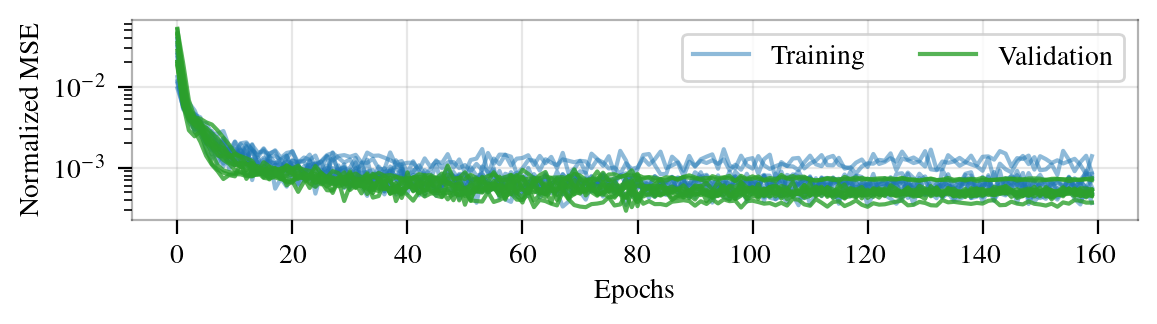

In [25]:
import subprocess 

fig_size = (6.49, 1.3)   # fit into diss format
eid = meta_info_lptn.iloc[0, :].loc['experiment_id']
trend_file = DATA_OUT_PATH.parent / 'node_estimates'/ 'indexed_trends' / f'expid_{eid}_lptn_trends.pkl.bz2'

if not Path.exists(trend_file):
    host = meta_info_lptn.query(f"experiment_id == {eid}").hostname.iloc[0]
    print(f"SecureCopy experiment {eid} from {host}")
    subprocess.run(f"scp {host}:{trend_file} {trend_file}", shell=True)
trend_df = pd.read_pickle(trend_file)
fig, ax = plt.subplots(figsize=fig_size, dpi=200)
for rep_i, rep_df in trend_df.groupby('rep'):
    ax.plot(rep_df.reset_index(drop=True).training,
            color='tab:blue', label='Training', alpha=0.5)
    if not rep_df.validation.isna().any():
        ax.plot(rep_df.reset_index(drop=True).validation,
                color='tab:green', label='Validation', alpha=0.8, zorder=3)
    if rep_i == 0:
        ax.legend(frameon=True, ncols=2)
ax.set_xlabel('Epochs')
#if ax == axes[0, 0] or ax == axes[1, 0]:
ax.set_ylabel('Normalized MSE')
ax.set_yscale('log')
prettify(ax)
fig.savefig(IMG_PATH / 'diss_lptn_trend_nadam.pdf', dpi=300, bbox_inches='tight')

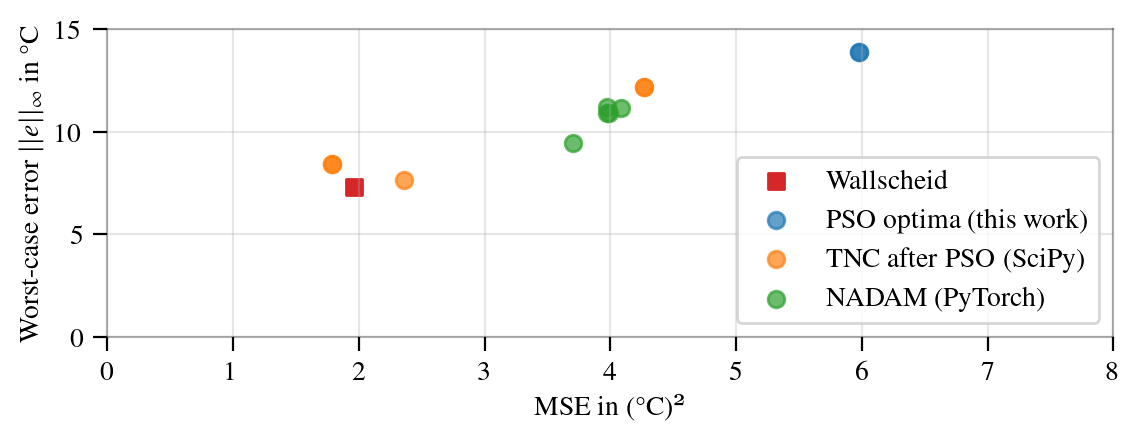

In [26]:
fig = plt.figure(dpi=200, figsize=(6.49, 2))
ax = fig.gca()

ax.scatter(Wallscheid_LPTN_score[0], Wallscheid_LPTN_score[1], color='tab:red', marker='s', label="Wallscheid")
ax.scatter([x[0] for x in my_PSO_best_5_scores], [x[1] for x in my_PSO_best_5_scores], label='PSO optima (this work)', alpha=0.7)
ax.scatter([x[0] for x in scipy_on_PSO_scores], [x[1] for x in scipy_on_PSO_scores], label="TNC after PSO (SciPy)", alpha=0.7)
ax.scatter(NADAM_scores[:, 0], NADAM_scores[:, 1], label='NADAM (PyTorch)', alpha=0.7)
ax.set_ylabel("Worst-case error $||e||_\infty$ in °C")
ax.set_xlabel('MSE in (°C)²')
ax.set_xlim(0, 8)
ax.set_ylim(0, 15)
ax.legend()
prettify(ax)
fig.savefig(IMG_PATH / "diss_lptn_comparison.pdf", dpi = 300, bbox_inches = "tight")